In [36]:
# Reference: https://www.kaggle.com/remekkinas/yolox-training-pipeline-cots-dataset-lb-0-507

In [118]:
import warnings
warnings.filterwarnings("ignore")

import ast
import os
# import json
import yaml
import pandas as pd
import torch
# import importlib
import cv2
import math
import numpy as np

from shutil import copyfile
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.model_selection import GroupKFold
from PIL import Image as Im
# from string import Template
from IPython.display import Image

TRAIN_PATH = './tensorflow-great-barrier-reef'

In [119]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_path(row):
    row['image_path'] = f'{TRAIN_PATH}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row

In [120]:
df = pd.read_csv(os.path.join(TRAIN_PATH, 'train.csv'))
df.head(5)

video_id  sequence  video_frame  sequence_frame image_id annotations
0         0     40258            0               0      0-0          []
1         0     40258            1               1      0-1          []
2         0     40258            2               2      0-2          []
3         0     40258            3               3      0-3          []
4         0     40258            4               4      0-4          []

In [121]:
# Taken only annotated photos
df["num_bbox"] = df['annotations'].apply(lambda x: str.count(x, 'x'))
df_train = df[df["num_bbox"]>=0]

#Annotations 
df_train['annotations'] = df_train['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df_train['bboxes'] = df_train.annotations.progress_apply(get_bbox)

#Images resolution
df_train["width"] = 1280
df_train["height"] = 720

#Path of images
df_train = df_train.progress_apply(get_path, axis=1)

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

In [122]:
NUM_FOLDS = 3
kf = GroupKFold(n_splits = NUM_FOLDS) 
df_train = df_train.reset_index(drop=True)
df_train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train, y = df_train.video_id.tolist(), groups=df_train.video_id.tolist())):
    df_train.loc[val_idx, 'fold'] = fold

df_train.head(5)

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   
2         0     40258            2               2      0-2          []   
3         0     40258            3               3      0-3          []   
4         0     40258            4               4      0-4          []   

   num_bbox bboxes  width  height  \
0         0     []   1280     720   
1         0     []   1280     720   
2         0     []   1280     720   
3         0     []   1280     720   
4         0     []   1280     720   

                                          image_path  fold  
0  ./tensorflow-great-barrier-reef/train_images/v...     2  
1  ./tensorflow-great-barrier-reef/train_images/v...     2  
2  ./tensorflow-great-barrier-reef/train_images/v...     2  
3  ./tensorflow-great-barrier-reef/train_images/v...     2  
4  ./tensorflow-great-barrier-reef/train_images/v...     2

In [123]:
bbox_count_per_fold = df_train.groupby(['fold'])['video_id'].value_counts()
bbox_count_per_fold

fold  video_id
0     2           8561
1     1           8232
2     0           6708
Name: video_id, dtype: int64

In [124]:
# # Number of 0 labels - 400
# # Number of labels per fold - 80
# NUM_ZERO_LABELS = 400
# NUM_LABELS_PER_FOLD = NUM_ZERO_LABELS / NUM_FOLDS

# indices_to_drop = []

# for fold in df_train['fold'].unique():
#     df_fold = df_train[df_train['fold']==fold]
#     df_fold = df_fold[df_fold['num_bbox']==0]
#     bbox_zero_count = {}
#     for video in df_fold['video_id'].unique():
#         print("here")
#         df_video = df_fold[df_fold['video_id']==video]
#         bbox_zero_count[video] = df_video.shape[0]


#     total_bbox_count = sum(bbox_zero_count.values())
#     print(f'Fold {fold} has {total_bbox_count} zero bboxes')
#     num_to_remove = {fold: math.ceil(count / total_bbox_count * NUM_LABELS_PER_FOLD) for fold, count in bbox_zero_count.items()}
#     print(bbox_zero_count)
#     print(num_to_remove)
    
#     for (video, drop_num) in num_to_remove.items():
#         indices = df_fold[df_fold['video_id'] == video].sample(n=drop_num, random_state=1).index.to_list()
#         indices_to_drop.extend(indices)

# print("Keeping {} unlabeled images".format(len(indices_to_drop)))
# zero_indices = df_train[df_train['num_bbox']==0]
# zero_indices = zero_indices.drop(indices_to_drop).index.to_list()
# # df_train = df_train.drop(zero_indices)

In [125]:
# Number of 0 labels - 400
# Number of labels per fold - 80
NUM_ZERO_LABELS = 400
SELECTED_FOLD = 0
FOLDS = df_train['fold'].unique()
TRAIN_FOLDS = np.delete(FOLDS, np.where(FOLDS == SELECTED_FOLD))
indices_to_drop = []
df_temp = df_train[df_train['fold'].isin(TRAIN_FOLDS)]
total_bbox_zero_count = df_temp[df_temp['num_bbox'] == 0].shape[0]

for fold in TRAIN_FOLDS:
        df_fold = df_train[df_train['fold']==fold]
        df_fold = df_fold[df_fold['num_bbox']==0]
        bbox_zero_count = df_fold.shape[0]

        print(f'Fold {fold} has {bbox_zero_count} zero bboxes')
        num_to_remove = {fold: math.ceil(bbox_zero_count / total_bbox_zero_count * NUM_ZERO_LABELS)}
        print(bbox_zero_count)
        print(num_to_remove)
        
        for (fold, drop_num) in num_to_remove.items():
            indices = df_fold[df_fold['fold'] == fold].sample(n=drop_num, random_state=1).index.to_list()
            indices_to_drop.extend(indices)

print("Keeping {} unlabeled images".format(len(indices_to_drop)))
val_df = df_train[df_train['fold'] == SELECTED_FOLD]

zero_indices = df_train[df_train['num_bbox']==0]
zero_indices = zero_indices.drop(indices_to_drop)
zero_indices = zero_indices.drop(val_df[val_df['num_bbox'] == 0].index.to_list()).index.to_list()

df_train = df_train.drop(zero_indices)
df_train = df_train.reset_index(drop=True)

Fold 2 has 4565 zero bboxes
4565
{2: 171}
Fold 1 has 6133 zero bboxes
6133
{1: 230}
Keeping 401 unlabeled images


In [126]:
bbox_count_per_fold = df_train.groupby(['fold'])['video_id'].value_counts()
bbox_count_per_fold

fold  video_id
0     2           8561
1     1           2329
2     0           2314
Name: video_id, dtype: int64

In [127]:
# df_train.drop(columns='fold', inplace=True)

In [128]:
# NUM_FOLDS = 5
# kf = GroupKFold(n_splits = NUM_FOLDS) 
# df_train = df_train.reset_index(drop=True)
# df_train['fold'] = -1
# for fold, (train_idx, val_idx) in enumerate(kf.split(df_train, y = df_train.video_id.tolist(), groups=df_train.sequence)):
#     df_train.loc[val_idx, 'fold'] = fold

# df_train.head(5)

In [131]:
HOME_DIR = "./" 
DATASET_PATH = 'dataset/images'
LABELS_PATH = 'dataset/labels'

os.makedirs(os.path.join(HOME_DIR, 'dataset'))

for path in [DATASET_PATH, LABELS_PATH]:
    os.makedirs(os.path.join(HOME_DIR, path))
    os.makedirs(os.path.join(HOME_DIR, path, 'train'))
    os.makedirs(os.path.join(HOME_DIR, path, 'val'))

In [ ]:
# for i in tqdm(range(len(df_train))):
#     row = df_train.loc[i]
#     # img = cv2.imread(row.image_path)
#     # img = gamma_enhance(cv2.filter2D(img, -1, sharp_filter), gamma=2)
#     # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     if row.fold != SELECTED_FOLD:
#         # cv2.imwrite(f'{HOME_DIR}{DATASET_PATH}/train/{row.image_id}.jpg', img)
#         copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/train/{row.image_id}.jpg')
#     else:
#         # cv2.imwrite(f'{HOME_DIR}{DATASET_PATH}/val/{row.image_id}.jpg', img)
#         copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/val/{row.image_id}.jpg') 

In [130]:
sharp_filter = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
def gamma_enhance(img, gamma=1.0):
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    return cv2.LUT(img, lookUpTable)

In [132]:
# SELECTED_FOLD = 0

for i in tqdm(range(len(df_train))):
    row = df_train.loc[i]
    img = cv2.imread(row.image_path)
    img = gamma_enhance(cv2.filter2D(img, -1, sharp_filter), gamma=2)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if row.fold != SELECTED_FOLD:
        cv2.imwrite(f'{HOME_DIR}{DATASET_PATH}/train/{row.image_id}.jpg', img)
        # copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/train/{row.image_id}.jpg')
    else:
        cv2.imwrite(f'{HOME_DIR}{DATASET_PATH}/val/{row.image_id}.jpg', img)
        # copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/val/{row.image_id}.jpg') 

  0%|          | 0/13204 [00:00<?, ?it/s]

In [133]:
print(f'Number of training files: {len(os.listdir(f"{HOME_DIR}{DATASET_PATH}/train/"))}')
print(f'Number of validation files: {len(os.listdir(f"{HOME_DIR}{DATASET_PATH}/val/"))}')

Number of training files: 4643
Number of validation files: 8561


In [134]:
# def dataset2yolo(df):
    
#     for row in df.itertuples():

#         if row.num_bbox == 0:
#             continue
        
#         path = f'{HOME_DIR}{LABELS_PATH}/val/{row.image_id}.txt'
        
#         bbox_list = row.bboxes
#         labels = []
        
#         for bbox in bbox_list:
#             x_min, y_min = bbox[0], bbox[1]
#             width_abs, height_abs = bbox[2], bbox[3]
            
#             x_center, y_center = x_min + width_abs/2, y_min + height_abs/2
            
#             x_center_norm, y_center_norm = x_center / row.width, y_center / row.height
#             width_norm, height_norm = width_abs / row.width, height_abs / row.height
            
#             labels.append("{} {} {} {} {}\n".format(0, x_center_norm, y_center_norm, width_norm, height_norm))
        
#         with open(path, 'w') as f:
#             f.writelines(labels)
        
#     print(f"Dataset to YOLO label format completed! Files: {len(df)}")
    
# df = pd.read_csv(os.path.join(TRAIN_PATH, 'train.csv'))

# # Taken only annotated photos
# df["num_bbox"] = df['annotations'].apply(lambda x: str.count(x, 'x'))

# #Annotations 
# df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
# df['bboxes'] = df.annotations.progress_apply(get_bbox)

# #Images resolution
# df["width"] = 1280
# df["height"] = 720

# #Path of images
# df = df.progress_apply(get_path, axis=1)

# for i in tqdm(range(len(df))):
#     row = df.loc[i]
#     copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/val/{row.image_id}.jpg')

# dataset2yolo(df)

In [135]:
def dataset2yolo(df):
    
    for row in df.itertuples():

        if row.num_bbox == 0:
            continue
        
        path = None
        if row.fold != SELECTED_FOLD:
            path = f'{HOME_DIR}{LABELS_PATH}/train/{row.image_id}.txt'
        else:
            path = f'{HOME_DIR}{LABELS_PATH}/val/{row.image_id}.txt'
        
        bbox_list = row.bboxes
        labels = []
        
        for bbox in bbox_list:
            x_min, y_min = bbox[0], bbox[1]
            width_abs, height_abs = bbox[2], bbox[3]
            
            x_center, y_center = x_min + width_abs/2, y_min + height_abs/2
            
            x_center_norm, y_center_norm = x_center / row.width, y_center / row.height
            width_norm, height_norm = width_abs / row.width, height_abs / row.height
            
            labels.append("{} {} {} {} {}\n".format(0, x_center_norm, y_center_norm, width_norm, height_norm))
        
        with open(path, 'w') as f:
            f.writelines(labels)
        
    print(f"Dataset to YOLO label format completed! Files: {len(df)}")

In [136]:
# Convert COTS dataset to YOLO label format and save
dataset2yolo(df_train)

Dataset to YOLO label format completed! Files: 13204


In [149]:
df_train[(df_train['fold'] == SELECTED_FOLD) & (df_train['num_bbox']>0)]

video_id  sequence  video_frame  sequence_frame image_id  \
8489          2     26651         4718            1046   2-4718   
8490          2     26651         4719            1047   2-4719   
8491          2     26651         4720            1048   2-4720   
8492          2     26651         4721            1049   2-4721   
8493          2     26651         4722            1050   2-4722   
...         ...       ...          ...             ...      ...   
13072         2     29859        10628            2856  2-10628   
13073         2     29859        10629            2857  2-10629   
13074         2     29859        10630            2858  2-10630   
13075         2     29859        10631            2859  2-10631   
13076         2     29859        10632            2860  2-10632   

                                             annotations  num_bbox  \
8489   [{'x': 227, 'y': 479, 'width': 42, 'height': 38}]         1   
8490   [{'x': 224, 'y': 489, 'width': 42, 'height': 38}]         1   
8491   [{'x': 220, 'y': 498, 'width': 42, 'height': 38}]         1   
8492   [{'x': 217, 'y': 508, 'width': 42, 'height': 38}]         1   
8493   [{'x': 211, 'y': 517, 'width': 36, 'height': 38}]         1   
...                                                  ...       ...   
13072   [{'x': 92, 'y': 532, 'width': 40, 'height': 37}]         1   
13073   [{'x': 78, 'y': 569, 'width': 40, 'height': 37}]         1   
13074   [{'x': 65, 'y': 606, 'width': 41, 'height': 37}]         1   
13075   [{'x': 51, 'y': 643, 'width': 44, 'height': 37}]         1   
13076   [{'x': 38, 'y': 681, 'width': 46, 'height': 37}]         1   

                     bboxes  width  height  \
8489   [[227, 479, 42, 38]]   1280     720   
8490   [[224, 489, 42, 38]]   1280     720   
8491   [[220, 498, 42, 38]]   1280     720   
8492   [[217, 508, 42, 38]]   1280     720   
8493   [[211, 517, 36, 38]]   1280     720   
...                     ...    ...     ...   
13072   [[92, 532, 40, 37]]   1280     720   
13073   [[78, 569, 40, 37]]   1280     720   
13074   [[65, 606, 41, 37]]   1280     720   
13075   [[51, 643, 44, 37]]   1280     720   
13076   [[38, 681, 46, 37]]   1280     720   

                                              image_path  fold  
8489   ./tensorflow-great-barrier-reef/train_images/v...     0  
8490   ./tensorflow-great-barrier-reef/train_images/v...     0  
8491   ./tensorflow-great-barrier-reef/train_images/v...     0  
8492   ./tensorflow-great-barrier-reef/train_images/v...     0  
8493   ./tensorflow-great-barrier-reef/train_images/v...     0  
...                                                  ...   ...  
13072  ./tensorflow-great-barrier-reef/train_images/v...     0  
13073  ./tensorflow-great-barrier-reef/train_images/v...     0  
13074  ./tensorflow-great-barrier-reef/train_images/v...     0  
13075  ./tensorflow-great-barrier-reef/train_images/v...     0  
13076  ./tensorflow-great-barrier-reef/train_images/v...     0  

[677 rows x 12 columns]

In [137]:
dataset_yaml_path = f'{HOME_DIR}dataset/dataset.yaml'
yaml_lines = [
    "# dataset root directory\n",
    "path: {}dataset\n".format(HOME_DIR),
    "\n# train and val data\n",
    "train: ../dataset/images/train\n",
    "val: ../dataset/images/val\n",
    "\n# number of classes\n",
    "nc: 1\n",
    "\n# class names\n",
    "names: ['starfish']\n",
]

with open(dataset_yaml_path, 'w') as f:
    f.writelines(yaml_lines)

In [138]:
%cat {dataset_yaml_path}

UsageError: Line magic function `%cat` not found.


In [139]:
print(len(os.listdir(HOME_DIR + LABELS_PATH + "/train/")))

4242


In [140]:
label_filename = df_train.iloc[1738].image_id
label_filename = HOME_DIR + LABELS_PATH + "/train/" + label_filename + ".txt"
# %cat {HOME_DIR}{LABELS_PATH}/train/{label_filename}
with open(label_filename, 'r') as f:
    print(f.readlines())

['0 0.580078125 0.8534722222222222 0.03046875 0.043055555555555555\n']


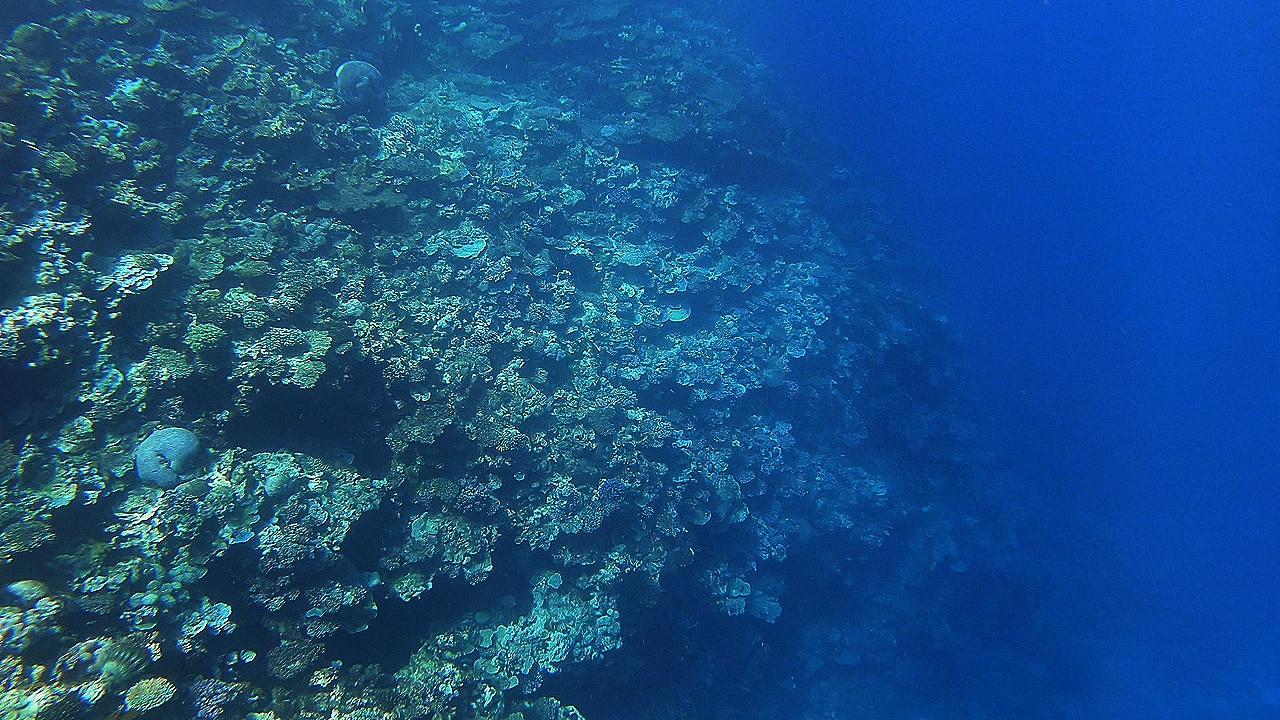

./dataset/images/train/0-12254.jpg
0 12254
[list([[98, 642, 56, 50], [463, 604, 41, 30]])]
['0', '0.0984375', '0.9263888888888889', '0.04375', '0.06944444444444445']
['0', '0.377734375', '0.8597222222222223', '0.03203125', '0.041666666666666664']
[[0.0, 98.0, 642.0, 56.0, 50.0], [0.0, 463.0, 604.0, 41.0, 30.0]]


In [141]:
image = sorted(os.listdir(HOME_DIR + DATASET_PATH + "/train/"))[234]
img = cv2.imread(HOME_DIR + DATASET_PATH + "/train/" + image.split('.')[0] + ".jpg")
new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display(Im.fromarray(new_img))
print(HOME_DIR + DATASET_PATH + "/train/" + image.split('.')[0] + ".jpg")

with open(HOME_DIR + LABELS_PATH + "/train/" + image.split('.')[0] + ".txt") as f:
    content = f.readlines()

video_id = int(image.split('-')[0])
video_frame = int(image.split('-')[-1].split('.')[0])
print(video_id, video_frame)
    
print(df_train[(df_train.video_id==video_id) & (df_train.video_frame==video_frame)].bboxes.values)
lines = []
for row in content:
    line = row.split("\n")[0].split(' ')
    print(line)
    for i in range(len(line)):
        line[i] = float(line[i])
    line[1] *= 1280
    line[2] *= 720
    line[3] *= 1280
    line[4] *= 720
    line[1] -= line[3]/2
    line[2] -= line[4]/2
    lines.append(line)

print(lines)

In [142]:
def draw_rectangle(img, content):
    for row in content:
        class_name, x0, y0, width, height = row
        x1, y1 = x0 + width, y0 + height
        x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
        cv2.rectangle(img, (x0, y0), (x1, y1), (0, 255, 0), 2)
    return img

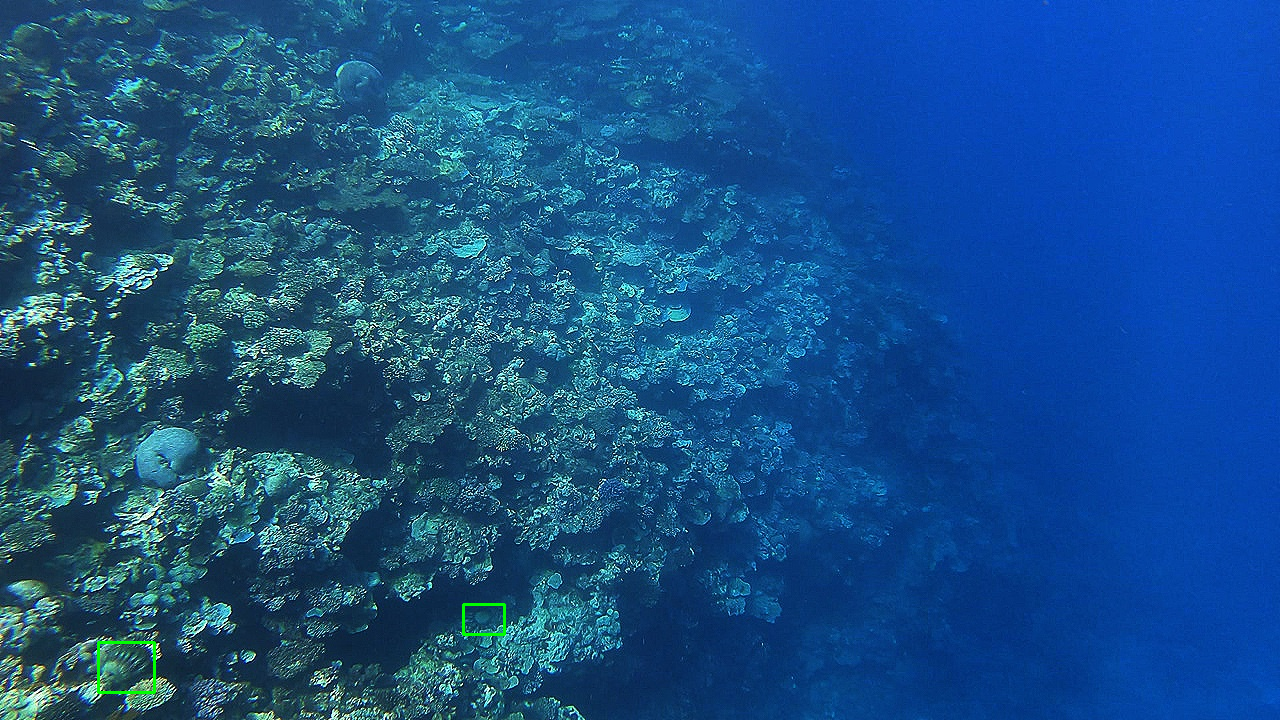

In [143]:
out_image = draw_rectangle(img, lines)
out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
display(Im.fromarray(out_image))

In [82]:
# %%bash
# git clone https://github.com/ultralytics/yolov5
# cd yolov5
# pip install -r requirements.txt

# pip install tensorflow==2.3.1 #Keep this version of TF as YOLOv5 works well with it.

In [11]:
print('All set. Using PyTorch version %s with %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

All set. Using PyTorch version 1.10.1+cu102 with _CudaDeviceProperties(name='NVIDIA GeForce RTX 2070', major=7, minor=5, total_memory=8191MB, multi_processor_count=36)


In [ ]:
# scipy==1.6.3 to avoid the missing GLIBCXX_3.4.26 error

!pip install scipy==1.6.3

In [12]:
!python ./yolov5/train.py --img 1280 --rect --batch 8 --epochs 1 --data ./dataset/dataset.yaml --weights yolov5s.pt

Traceback (most recent call last):
  File "./yolov5/train.py", line 19, in <module>
    import torch
  File "C:\Ayush\github\cots-object-detection\cots2\lib\site-packages\torch\__init__.py", line 124, in <module>
    raise err
OSError: [WinError 1455] The paging file is too small for this operation to complete. Error loading "C:\Ayush\github\cots-object-detection\cots2\lib\site-packages\torch\lib\caffe2_detectron_ops_gpu.dll" or one of its dependencies.


In [ ]:
!ls /kaggle/working/yolov5/runs/train/exp3

In [ ]:
# from utils.plots import plot_results
# plot_results('path/to/results.csv')  # plot 'results.csv' as 'results.png'

In [ ]:
Image(filename='/kaggle/working/yolov5/runs/train/exp3/val_batch0_pred.jpg', width=1000)

In [ ]:
#Plotting the first image
Image(filename='/kaggle/working/yolov5/runs/train/exp3/results.png', width=415)